# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

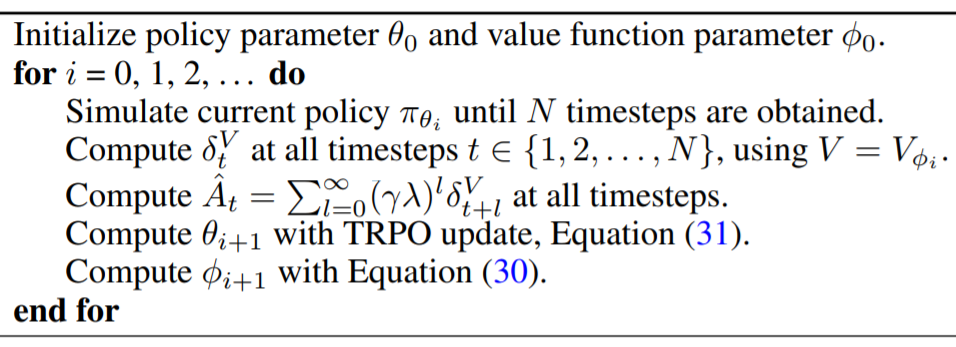

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from SpiderEnv.SpiderEnv_many import SpiderEnv

critic_learning_rate = 1e-3
actor_learning_rate = 1e-4
epochs_number = 3000000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

angle_normalization = 135

env_name = 'SpiderEnv_many_restricted'
environments_count = 20

# This code gets action and observation space sizes for 1D tasks
env = SpiderEnv()
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
critic_observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]
actor_observation_space = 20

## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = SpiderEnv()
        env.reset()
        for i in range(int(200*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, actor_observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, actor_observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, critic_observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)

actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0724 09:36:33.704987  9504 deprecation.py:323] From <ipython-input-4-475ee40c1e11>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0724 09:36:33.708951  9504 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 09:36:34.143733  9504 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [9]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

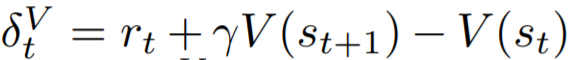

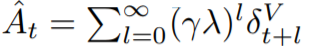

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = np.array([[0 for i in range(critic_observation_space)] for i in range(envs_number)])
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations[:, :actor_observation_space]})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions * angle_normalization)
            observations /= angle_normalization
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-3.02415947e-01,  6.66666667e-01, -2.85114458e-01, -1.04504931e-01,
       -1.24739866e-01,  1.80727252e-02,  0.00000000e+00,  0.00000000e+00,
       -6.66666667e-01,  0.00000000e+00, -6.66666667e-01, -1.77835747e-01,
       -4.50763731e-01,  0.00000000e+00, -1.46372096e-01,  0.00000000e+00,
       -3.99116036e-01, -2.49917207e-01,  7.40740741e-03,  0.00000000e+00,
        7.40740741e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.37482245e-03,  2.42270019e-04,  9.65404883e-05,  6.43166815e-04,
        7.32988412e-03,  2.47085316e-04,  8.34486358e-05,  1.03656571e-03,
        6.84048524e-03, -2.64499794e-03, -3.29418749e-04,  9.86364760e-04,
        4.54160502e-03, -5.75865229e-03, -7.85630241e-04,  6.81334922e-04,
        7.02387871e-03,  2.58065530e-04,  3.76431948e-05,  2.33811839e-03,
        6.84334215e-03,  1.60316504e-03,  4.86301468e-04,  2.28729655e-03,
        5.99013595e-03,  3.67692006e-03,  1.18194766e-03,  2.01772504e-03,
        7.4027760

## Train agent 

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [13]:
max_value = 4000

In [ ]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-A2C-reward({value}).ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
        with open(f'models/{env_name}-A2C-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)
            
    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                            actor.state_ph: np.array(batch[:, 0].tolist())[:, :actor_observation_space],
                                            actor.action_ph: np.array(batch[:, 1].tolist()),
                                            actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                            critic.state_ph: np.array(batch[:, 0].tolist()),
                                            critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)

Charging generators


Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7195).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7496).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7564).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7630).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7821).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7985).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8088).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8387).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8414).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8572).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8937).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(9237).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-rewa

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


In [24]:
with open(f'models/{env_name}-A2C-reward(6069)_all.history', 'wb') as f:
    pickle.dump(history, f)

## Plot results

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'SpiderEnv_many_restricted')

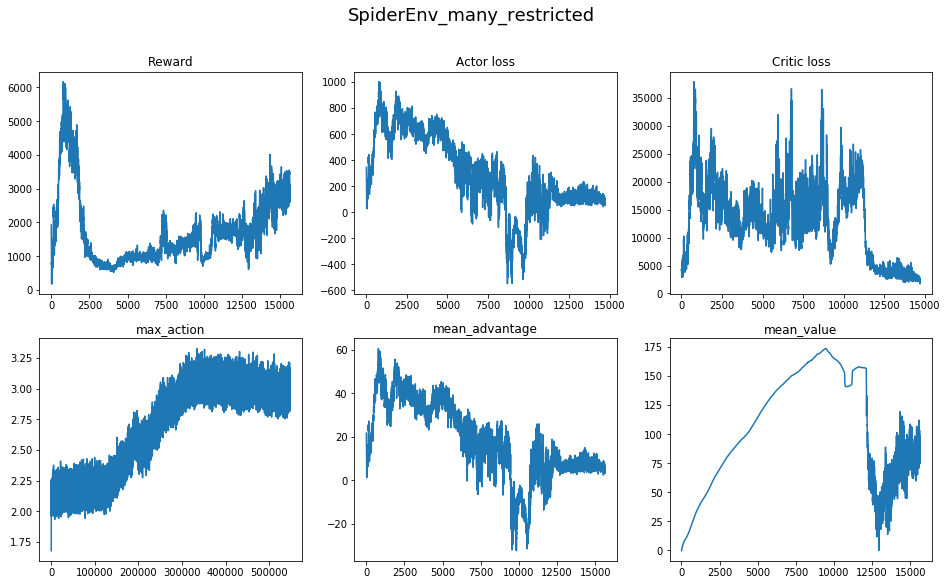

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [15]:
observations = env.reset()[:actor_observation_space].astype(np.float32) / angle_normalization

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})

    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0] * angle_normalization)
    observations = observations[:actor_observation_space].astype(np.float32) / angle_normalization

    if dones:
        observations = env.reset()[:actor_observation_space].astype(np.float32) / angle_normalization
        print('Done')

Creating window glfw
Done
Pressed ESC
Quitting.


NameError: name 'exit' is not defined

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

In [ ]:
# import pickle
# with open('logs/history.file', 'rb') as f:
#     history = pickle.load(f)

In [7]:
saver = tf.train.Saver()
saver.restore(sess, "./models/SpiderEnv_many_restricted-A2C-reward(11905).ckpt")

W0724 09:36:41.279795  9504 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

# import pickle
# with open('logs/history.file', 'rb') as f:
#     history = pickle.load(f)

# saver = tf.train.Saver()
# saver.restore(sess, "./models/SpiderEnv-A2C-reward(10802).ckpt")

# Real Robot


In [8]:
import numpy as np
from ServotorAPI import ServotorAPI
s = ServotorAPI(degree_type="std")

Start listening serial process
Start receiving data process


In [13]:
import time

observations = [0 for i in range(20)]
angles_bias = np.array([-(i > 5) * 45 for i in range(18)])

for i in range(10000):
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations[:actor_observation_space]]})[0]
    #actions = np.array([np.array([-(i > 5) * 45 for i in range(18)])]) / angle_normalization
    
    angles = list(map(int, (actions * angle_normalization + angles_bias + 90).tolist()))
    angles = np.clip(angles, 0, 180)
    s.rotate_servos(angles.tolist())
    
    observations = actions
    observations = np.append(observations, [1, 0])
    time.sleep(0.1)
    
s.kill_all_servos()

[76, 84, 141, 86, 47, 180, 0, 14, 28, 0, 0, 180, 83, 180, 180, 180, 109, 155]
b'LT\x8dV/\xb4\x00\x0e\x1c\x00\x00\xb4S\xb4\xb4\xb4m\x9b'
[180, 180, 0, 25, 0, 123, 0, 0, 0, 23, 0, 0, 34, 87, 180, 22, 180, 0]
b'\xb4\xb4\x00\x19\x00{\x00\x00\x00\x17\x00\x00"W\xb4\x16\xb4\x00'
[26, 180, 0, 107, 31, 180, 0, 0, 0, 0, 0, 180, 116, 45, 180, 42, 0, 180]
b'\x1a\xb4\x00k\x1f\xb4\x00\x00\x00\x00\x00\xb4t-\xb4*\x00\xb4'
[68, 180, 90, 0, 127, 124, 0, 0, 0, 14, 0, 180, 180, 0, 180, 61, 79, 43]
b'D\xb4Z\x00\x7f|\x00\x00\x00\x0e\x00\xb4\xb4\x00\xb4=O+'
[59, 180, 180, 2, 25, 119, 0, 0, 0, 35, 0, 180, 0, 58, 174, 128, 21, 132]
b';\xb4\xb4\x02\x19w\x00\x00\x00#\x00\xb4\x00:\xae\x80\x15\x84'
[86, 180, 0, 142, 0, 180, 88, 0, 0, 42, 8, 180, 166, 180, 168, 0, 41, 155]
b'V\xb4\x00\x8e\x00\xb4X\x00\x00*\x08\xb4\xa6\xb4\xa8\x00)\x9b'
[83, 180, 71, 0, 105, 165, 0, 0, 0, 21, 0, 180, 147, 77, 180, 0, 162, 180]
b'S\xb4G\x00i\xa5\x00\x00\x00\x15\x00\xb4\x93M\xb4\x00\xa2\xb4'
[180, 180, 78, 0, 66, 180, 0, 0, 88, 0, 0, 

[175, 180, 18, 41, 44, 180, 0, 0, 37, 0, 76, 180, 180, 0, 180, 128, 11, 162]
b'\xaf\xb4\x12),\xb4\x00\x00%\x00L\xb4\xb4\x00\xb4\x80\x0b\xa2'
[21, 180, 6, 0, 0, 84, 0, 0, 59, 23, 0, 142, 88, 73, 180, 180, 7, 0]
b'\x15\xb4\x06\x00\x00T\x00\x00;\x17\x00\x8eXI\xb4\xb4\x07\x00'
[27, 180, 0, 56, 0, 180, 0, 15, 0, 0, 0, 180, 37, 140, 180, 45, 0, 139]
b'\x1b\xb4\x008\x00\xb4\x00\x0f\x00\x00\x00\xb4%\x8c\xb4-\x00\x8b'
[138, 180, 144, 0, 33, 128, 0, 1, 29, 0, 89, 180, 0, 0, 180, 73, 157, 68]
b'\x8a\xb4\x90\x00!\x80\x00\x01\x1d\x00Y\xb4\x00\x00\xb4I\x9dD'
[163, 136, 0, 97, 0, 151, 0, 54, 1, 0, 0, 180, 157, 168, 180, 14, 32, 124]
b'\xa3\x88\x00a\x00\x97\x006\x01\x00\x00\xb4\x9d\xa8\xb4\x0e |'
[30, 180, 0, 13, 180, 84, 0, 0, 104, 69, 0, 180, 139, 0, 32, 0, 0, 180]
b'\x1e\xb4\x00\r\xb4T\x00\x00hE\x00\xb4\x8b\x00 \x00\x00\xb4'
[88, 180, 180, 92, 0, 109, 0, 0, 23, 55, 26, 180, 180, 0, 180, 104, 148, 123]
b'X\xb4\xb4\\\x00m\x00\x00\x177\x1a\xb4\xb4\x00\xb4h\x94{'
[52, 180, 0, 91, 134, 179, 56, 0, 85, 1

[180, 180, 180, 165, 180, 4, 0, 104, 32, 93, 100, 56, 17, 93, 166, 149, 173, 88]
b'\xb4\xb4\xb4\xa5\xb4\x04\x00h ]d8\x11]\xa6\x95\xadX'
[180, 121, 163, 60, 180, 0, 0, 113, 0, 0, 0, 0, 35, 180, 56, 0, 180, 29]
b'\xb4y\xa3<\xb4\x00\x00q\x00\x00\x00\x00#\xb48\x00\xb4\x1d'
[100, 180, 101, 0, 0, 105, 0, 0, 0, 0, 0, 86, 109, 133, 171, 0, 4, 0]
b'd\xb4e\x00\x00i\x00\x00\x00\x00\x00Vm\x85\xab\x00\x04\x00'
[180, 163, 100, 26, 0, 180, 0, 8, 0, 0, 0, 180, 146, 59, 180, 149, 0, 124]
b'\xb4\xa3d\x1a\x00\xb4\x00\x08\x00\x00\x00\xb4\x92;\xb4\x95\x00|'
[180, 119, 44, 0, 77, 154, 0, 0, 0, 2, 0, 122, 66, 0, 41, 103, 80, 86]
b'\xb4w,\x00M\x9a\x00\x00\x00\x02\x00zB\x00)gPV'
[131, 180, 0, 0, 148, 0, 0, 0, 0, 23, 0, 180, 0, 48, 180, 0, 180, 180]
b'\x83\xb4\x00\x00\x94\x00\x00\x00\x00\x17\x00\xb4\x000\xb4\x00\xb4\xb4'
[28, 180, 14, 122, 0, 180, 0, 0, 0, 0, 0, 180, 0, 0, 180, 69, 0, 130]
b'\x1c\xb4\x0ez\x00\xb4\x00\x00\x00\x00\x00\xb4\x00\x00\xb4E\x00\x82'
[180, 180, 48, 0, 74, 180, 0, 0, 41, 180, 0, 180, 36,

[21, 18, 156, 180, 84, 67, 12, 0, 0, 102, 0, 68, 9, 180, 90, 131, 30, 31]
b'\x15\x12\x9c\xb4TC\x0c\x00\x00f\x00D\t\xb4Z\x83\x1e\x1f'
[180, 180, 43, 43, 0, 180, 57, 0, 0, 0, 140, 0, 0, 161, 180, 115, 126, 12]
b'\xb4\xb4++\x00\xb49\x00\x00\x00\x8c\x00\x00\xa1\xb4s~\x0c'
[10, 180, 81, 59, 0, 122, 0, 0, 0, 12, 0, 180, 7, 180, 139, 0, 97, 0]
b'\n\xb4Q;\x00z\x00\x00\x00\x0c\x00\xb4\x07\xb4\x8b\x00a\x00'
[61, 142, 50, 61, 65, 180, 4, 0, 67, 70, 0, 180, 79, 180, 149, 180, 20, 180]
b'=\x8e2=A\xb4\x04\x00CF\x00\xb4O\xb4\x95\xb4\x14\xb4'
[92, 180, 10, 0, 51, 126, 0, 0, 0, 109, 0, 180, 0, 0, 180, 141, 6, 0]
b'\\\xb4\n\x003~\x00\x00\x00m\x00\xb4\x00\x00\xb4\x8d\x06\x00'
[25, 136, 54, 0, 0, 180, 86, 0, 0, 0, 0, 180, 149, 180, 180, 0, 0, 180]
b'\x19\x886\x00\x00\xb4V\x00\x00\x00\x00\xb4\x95\xb4\xb4\x00\x00\xb4'
[0, 76, 124, 20, 0, 91, 0, 0, 25, 139, 0, 180, 180, 0, 180, 180, 0, 180]
b'\x00L|\x14\x00[\x00\x00\x19\x8b\x00\xb4\xb4\x00\xb4\xb4\x00\xb4'
[125, 142, 0, 85, 41, 180, 46, 0, 0, 0, 0, 85, 0, 20

[180, 168, 0, 0, 24, 180, 0, 0, 0, 49, 5, 45, 56, 180, 68, 66, 0, 180]
b'\xb4\xa8\x00\x00\x18\xb4\x00\x00\x001\x05-8\xb4DB\x00\xb4'
[90, 180, 0, 0, 0, 89, 0, 0, 0, 0, 102, 180, 149, 0, 180, 0, 77, 3]
b'Z\xb4\x00\x00\x00Y\x00\x00\x00\x00f\xb4\x95\x00\xb4\x00M\x03'
[0, 180, 59, 0, 0, 180, 141, 0, 0, 84, 0, 180, 120, 0, 152, 0, 0, 180]
b'\x00\xb4;\x00\x00\xb4\x8d\x00\x00T\x00\xb4x\x00\x98\x00\x00\xb4'
[130, 180, 0, 148, 88, 0, 82, 0, 180, 0, 155, 180, 105, 0, 180, 0, 149, 180]
b'\x82\xb4\x00\x94X\x00R\x00\xb4\x00\x9b\xb4i\x00\xb4\x00\x95\xb4'
[56, 0, 180, 158, 180, 7, 54, 169, 0, 132, 0, 180, 113, 180, 32, 180, 0, 180]
b'8\x00\xb4\x9e\xb4\x076\xa9\x00\x84\x00\xb4q\xb4 \xb4\x00\xb4'
[180, 58, 105, 80, 180, 138, 177, 75, 67, 85, 180, 0, 106, 180, 180, 48, 171, 32]
b'\xb4:iP\xb4\x8a\xb1KCU\xb4\x00j\xb4\xb40\xab '
[93, 91, 180, 109, 98, 0, 0, 76, 0, 0, 0, 0, 78, 180, 180, 101, 180, 0]
b'][\xb4mb\x00\x00L\x00\x00\x00\x00N\xb4\xb4e\xb4\x00'
[130, 0, 171, 32, 178, 180, 0, 180, 0, 0, 11, 0, 27, 1

[180, 180, 0, 64, 159, 85, 0, 120, 0, 0, 0, 24, 35, 128, 180, 0, 24, 180]
b'\xb4\xb4\x00@\x9fU\x00x\x00\x00\x00\x18#\x80\xb4\x00\x18\xb4'
[69, 180, 109, 0, 15, 0, 0, 0, 23, 0, 0, 117, 92, 0, 180, 2, 28, 18]
b'E\xb4m\x00\x0f\x00\x00\x00\x17\x00\x00u\\\x00\xb4\x02\x1c\x12'
[16, 180, 11, 180, 147, 180, 4, 0, 0, 19, 0, 180, 121, 70, 180, 106, 0, 180]
b'\x10\xb4\x0b\xb4\x93\xb4\x04\x00\x00\x13\x00\xb4yF\xb4j\x00\xb4'
[180, 180, 89, 50, 115, 64, 0, 0, 28, 87, 51, 0, 138, 100, 98, 180, 0, 64]
b'\xb4\xb4Y2s@\x00\x00\x1cW3\x00\x8adb\xb4\x00@'
[124, 180, 0, 0, 32, 108, 0, 0, 0, 0, 0, 89, 180, 114, 180, 19, 103, 160]
b'|\xb4\x00\x00 l\x00\x00\x00\x00\x00Y\xb4r\xb4\x13g\xa0'
[15, 180, 46, 0, 71, 91, 0, 0, 162, 0, 23, 180, 0, 0, 180, 66, 168, 118]
b'\x0f\xb4.\x00G[\x00\x00\xa2\x00\x17\xb4\x00\x00\xb4B\xa8v'
[0, 0, 0, 161, 0, 180, 0, 125, 0, 125, 0, 180, 180, 129, 0, 86, 131, 56]
b'\x00\x00\x00\xa1\x00\xb4\x00}\x00}\x00\xb4\xb4\x81\x00V\x838'
[110, 180, 0, 0, 180, 180, 0, 0, 50, 0, 0, 180, 180, 0, 1

[123, 180, 18, 0, 140, 59, 0, 0, 21, 21, 0, 180, 54, 48, 96, 116, 107, 41]
b'{\xb4\x12\x00\x8c;\x00\x00\x15\x15\x00\xb460`tk)'
[46, 91, 154, 0, 0, 180, 65, 0, 0, 0, 36, 180, 138, 49, 180, 17, 80, 8]
b'.[\x9a\x00\x00\xb4A\x00\x00\x00$\xb4\x8a1\xb4\x11P\x08'
[41, 124, 154, 147, 44, 180, 0, 55, 161, 0, 0, 180, 180, 0, 180, 0, 46, 180]
b')|\x9a\x93,\xb4\x007\xa1\x00\x00\xb4\xb4\x00\xb4\x00.\xb4'
[180, 0, 137, 124, 180, 0, 0, 84, 79, 84, 0, 158, 54, 166, 122, 180, 95, 158]
b'\xb4\x00\x89|\xb4\x00\x00TOT\x00\x9e6\xa6z\xb4_\x9e'
[103, 48, 29, 180, 180, 40, 61, 0, 34, 160, 0, 0, 65, 180, 11, 88, 47, 57]
b'g0\x1d\xb4\xb4(=\x00"\xa0\x00\x00A\xb4\x0bX/9'
[180, 180, 50, 0, 180, 48, 0, 18, 0, 0, 58, 1, 109, 180, 166, 2, 180, 180]
b'\xb4\xb42\x00\xb40\x00\x12\x00\x00:\x01m\xb4\xa6\x02\xb4\xb4'
[134, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 39, 148, 98, 168, 32, 20]
b"\x86\xb4\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4'\x94b\xa8 \x14"
[122, 108, 0, 0, 10, 117, 0, 0, 0, 0, 0, 180, 64, 6, 126, 0, 5, 179]
b'zl

[144, 180, 180, 49, 0, 167, 25, 0, 0, 0, 49, 180, 7, 0, 180, 0, 144, 0]
b'\x90\xb4\xb41\x00\xa7\x19\x00\x00\x001\xb4\x07\x00\xb4\x00\x90\x00'
[0, 180, 0, 0, 0, 180, 67, 67, 64, 23, 0, 180, 102, 82, 105, 0, 180, 84]
b'\x00\xb4\x00\x00\x00\xb4CC@\x17\x00\xb4fRi\x00\xb4T'
[96, 180, 77, 180, 0, 71, 28, 0, 3, 177, 0, 180, 180, 0, 146, 0, 0, 124]
b'`\xb4M\xb4\x00G\x1c\x00\x03\xb1\x00\xb4\xb4\x00\x92\x00\x00|'
[41, 121, 0, 96, 180, 180, 0, 19, 172, 148, 0, 180, 0, 117, 180, 0, 180, 157]
b')y\x00`\xb4\xb4\x00\x13\xac\x94\x00\xb4\x00u\xb4\x00\xb4\x9d'
[0, 0, 136, 180, 0, 0, 0, 14, 0, 100, 0, 10, 125, 180, 66, 180, 134, 41]
b'\x00\x00\x88\xb4\x00\x00\x00\x0e\x00d\x00\n}\xb4B\xb4\x86)'
[6, 180, 69, 0, 156, 180, 7, 34, 68, 0, 180, 180, 66, 61, 180, 0, 36, 180]
b'\x06\xb4E\x00\x9c\xb4\x07"D\x00\xb4\xb4B=\xb4\x00$\xb4'
[32, 161, 180, 174, 90, 25, 0, 0, 0, 0, 0, 180, 0, 77, 16, 142, 180, 8]
b' \xa1\xb4\xaeZ\x19\x00\x00\x00\x00\x00\xb4\x00M\x10\x8e\xb4\x08'
[180, 0, 0, 70, 174, 180, 11, 42, 180, 106, 

[77, 166, 0, 0, 12, 57, 0, 0, 0, 0, 0, 180, 72, 113, 180, 4, 51, 102]
b'M\xa6\x00\x00\x0c9\x00\x00\x00\x00\x00\xb4Hq\xb4\x043f'
[49, 67, 97, 3, 0, 120, 0, 34, 0, 0, 0, 180, 180, 0, 101, 68, 82, 3]
b'1Ca\x03\x00x\x00"\x00\x00\x00\xb4\xb4\x00eDR\x03'
[111, 180, 0, 50, 180, 141, 0, 0, 66, 0, 0, 180, 89, 0, 65, 180, 44, 180]
b'o\xb4\x002\xb4\x8d\x00\x00B\x00\x00\xb4Y\x00A\xb4,\xb4'
[121, 180, 170, 0, 96, 180, 0, 0, 55, 0, 18, 128, 58, 0, 180, 25, 74, 17]
b'y\xb4\xaa\x00`\xb4\x00\x007\x00\x12\x80:\x00\xb4\x19J\x11'
[169, 112, 137, 13, 137, 180, 0, 48, 0, 0, 0, 180, 0, 180, 180, 24, 0, 107]
b'\xa9p\x89\r\x89\xb4\x000\x00\x00\x00\xb4\x00\xb4\xb4\x18\x00k'
[41, 180, 0, 63, 134, 112, 0, 0, 0, 0, 0, 48, 67, 105, 180, 171, 80, 0]
b')\xb4\x00?\x86p\x00\x00\x00\x00\x000Ci\xb4\xabP\x00'
[38, 180, 0, 0, 50, 180, 0, 0, 153, 93, 0, 158, 122, 112, 139, 139, 0, 34]
b'&\xb4\x00\x002\xb4\x00\x00\x99]\x00\x9ezp\x8b\x8b\x00"'
[35, 161, 101, 37, 88, 180, 0, 0, 0, 71, 0, 180, 180, 21, 180, 0, 0, 93]
b'#\xa1e%X

[0, 0, 124, 158, 180, 180, 3, 170, 0, 105, 0, 3, 180, 180, 113, 180, 51, 180]
b'\x00\x00|\x9e\xb4\xb4\x03\xaa\x00i\x00\x03\xb4\xb4q\xb43\xb4'
[180, 180, 123, 85, 39, 38, 56, 0, 111, 0, 180, 0, 37, 158, 145, 164, 180, 0]
b"\xb4\xb4{U'&8\x00o\x00\xb4\x00%\x9e\x91\xa4\xb4\x00"
[51, 97, 80, 25, 180, 180, 7, 30, 0, 56, 0, 0, 0, 180, 150, 109, 13, 180]
b'3aP\x19\xb4\xb4\x07\x1e\x008\x00\x00\x00\xb4\x96m\r\xb4'
[106, 180, 31, 0, 0, 20, 30, 0, 0, 0, 34, 52, 170, 125, 180, 136, 0, 0]
b'j\xb4\x1f\x00\x00\x14\x1e\x00\x00\x00"4\xaa}\xb4\x88\x00\x00'
[0, 147, 0, 28, 39, 180, 69, 0, 3, 0, 0, 180, 0, 49, 180, 25, 0, 112]
b"\x00\x93\x00\x1c'\xb4E\x00\x03\x00\x00\xb4\x001\xb4\x19\x00p"
[132, 84, 0, 180, 68, 76, 55, 0, 30, 143, 23, 180, 2, 109, 180, 8, 38, 38]
b'\x84T\x00\xb4DL7\x00\x1e\x8f\x17\xb4\x02m\xb4\x08&&'
[157, 150, 42, 0, 72, 118, 0, 67, 0, 0, 0, 0, 0, 180, 107, 0, 0, 91]
b'\x9d\x96*\x00Hv\x00C\x00\x00\x00\x00\x00\xb4k\x00\x00['
[179, 180, 103, 0, 6, 180, 0, 5, 0, 0, 0, 180, 56, 0, 180, 0, 109

[116, 180, 111, 49, 63, 180, 0, 36, 58, 0, 0, 56, 0, 180, 180, 44, 89, 75]
b't\xb4o1?\xb4\x00$:\x00\x008\x00\xb4\xb4,YK'
[180, 165, 24, 0, 16, 114, 0, 80, 70, 0, 9, 11, 2, 180, 180, 0, 144, 0]
b'\xb4\xa5\x18\x00\x10r\x00PF\x00\t\x0b\x02\xb4\xb4\x00\x90\x00'
[60, 180, 180, 52, 15, 59, 0, 0, 0, 0, 0, 156, 127, 94, 78, 180, 110, 139]
b'<\xb4\xb44\x0f;\x00\x00\x00\x00\x00\x9c\x7f^N\xb4n\x8b'
[180, 180, 139, 0, 5, 180, 0, 0, 21, 0, 104, 180, 0, 0, 180, 63, 78, 180]
b'\xb4\xb4\x8b\x00\x05\xb4\x00\x00\x15\x00h\xb4\x00\x00\xb4?N\xb4'
[165, 180, 11, 0, 0, 180, 0, 0, 124, 0, 0, 180, 0, 56, 88, 66, 0, 69]
b'\xa5\xb4\x0b\x00\x00\xb4\x00\x00|\x00\x00\xb4\x008XB\x00E'
[0, 180, 101, 81, 0, 170, 92, 0, 0, 72, 0, 180, 180, 0, 180, 180, 180, 136]
b'\x00\xb4eQ\x00\xaa\\\x00\x00H\x00\xb4\xb4\x00\xb4\xb4\xb4\x88'
[92, 58, 70, 180, 180, 36, 0, 0, 180, 6, 0, 180, 104, 0, 135, 0, 136, 180]
b'\\:F\xb4\xb4$\x00\x00\xb4\x06\x00\xb4h\x00\x87\x00\x88\xb4'
[3, 35, 180, 3, 87, 0, 0, 180, 163, 180, 57, 0, 180, 180, 1

KeyboardInterrupt: 

In [21]:
s.kill_all_servos()
s.close_connection()

recieving data process was stoppedport listening process was stopped

serial connection stopped


In [ ]:




for i in range(100):
    n = np.sin(i / 5) * 90
